In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 22 16:12:02 2021

@author: jonathancorrales
"""

import pandas as pd
import matplotlib as mpl
from mplsoccer.pitch import Pitch
from mplsoccer import add_image
from mplsoccer.pitch import VerticalPitch
from matplotlib.colors import to_rgba
import numpy as np
#from mplsoccer.statsbomb import read_event, EVENT_SLUG
import matplotlib.pyplot as plt
#from matplotlib import cm
#from matplotlib import colorbar
#from matplotlib.colors import LinearSegmentedColormap
#from highlight_text import fig_text
import math
from PIL import Image
from urllib.request import urlopen

In [2]:
import os
#os.chdir("/users/jonathancorrales/documents/Scout/ADG/XML/Clausura 2022")
os.chdir("/users/jonathancorrales/documents/Scout/xml data/CRC LFP/Clausura 2023")

fileName="05-03-2023--Costa-Rica--Primera-DivisionSporting-FC-San-Jose-2-1-Cartagines20230306-92010-in3j3t.xml"

#teamA = 'Cartagines'
#teamB = 'Jicaral'

#datestr = '01_04_2022'

datestr = fileName[0:10]

#minHome = 55
#minOpp = 57


In [3]:
import xmltodict
import json
with open(fileName) as xml_file:
    my_dict=xmltodict.parse(xml_file.read())
xml_file.close()
json_data=json.dumps(my_dict)
#print(json_data)


In [4]:
match_id_required = '001'

# Load in the data
file_name=str(match_id_required)+'.json'

#Load in all match events 
data = json.loads(json_data)

dataAll = data["file"]

dataAllInstances = dataAll["ALL_INSTANCES"]


In [5]:
lineups  = dataAll["ROWS"]

lineups  = lineups["row"]

dataInstance = dataAllInstances["instance"]




In [6]:
from pandas.io.json import json_normalize

lineups_df = pd.json_normalize(lineups)

lineups_df['sort_order'] = lineups_df['sort_order'].astype(float) 

lineups_df = lineups_df[lineups_df["sort_order"] > 0]


lineups_TeamA = lineups_df[lineups_df['R']=='51400']
lineups_TeamB = lineups_df[lineups_df['R']=='14649']


In [7]:
# Load the Club/ Statsbomb logos
# these are the property of the respective clubs/ StatsBomb.
BARCA_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/commons/'
                  'thumb/7/70/Escudo_Sporting_SJ.svg/237px-Escudo_Sporting_SJ.svg.png')
DEPORTIVO_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/en/2/24/CSC_CR_logo.png')

barca_logo = Image.open(urlopen(BARCA_LOGO_URL))
deportivo_logo = Image.open(urlopen(DEPORTIVO_LOGO_URL))


In [8]:
#get the nested structure into a dataframe 
#store the dataframe in a dictionary with the match id as key (remove '.json' from string)

df = pd.json_normalize(dataInstance, sep = "_").assign(match_id = file_name[:-5])

df = pd.json_normalize(dataInstance).assign(match_id = file_name[:-5])


df2 = pd.concat([df['ID'], df['start'], df['end'], df['code'], df['pos_x'],df['pos_y'],df['match_id'],df['label'].apply(pd.Series)], axis=1)
 
df3 = pd.concat([df2['ID'], df2['start'], df2['end'], df2['code'], df2['pos_x'],df2['pos_y'],df2['match_id'],df2[0].apply(pd.Series),df2[1].apply(pd.Series),df2[2].apply(pd.Series)], axis=1)

list(df3.columns)

df3.columns = ['ID',
 'start',
 'end',
 'code',
 'pos_x',
 'pos_y',
 'match_id',
 0,
 'groupTeam',
 'Team',
 0,
 'groupAction',
 'Action',
 0,
 'groupHalf',
 'Half']


In [9]:
passes_actions = ['Passes accurate', 'Passes (inaccurate)']
defensive_actions = ['Tackles','Interceptions','Fouls','Challenges (won)']


In [10]:
df3['start_min'] = df3['start'].astype(float) / 60
df3['end_min'] =   df3['end'].astype(float) / 60


name_sort_order = dict(zip(lineups_df['code'], lineups_df['sort_order']))
df3['sort_order'] = df3['code'].map(name_sort_order).fillna('')


In [11]:
m = df3.code.isin(lineups_TeamA.code)
df4 = df3[m]

row_1=df4.head(1)

teamA = row_1['Team'].iloc[0]

m = df3.code.isin(lineups_TeamB.code)
df4 = df3[m]

row_1=df4.head(1)
teamB = row_1['Team'].iloc[0]



In [12]:
#filter df to get only the team we want
df3 = df3[df3['Team']==teamA]


In [13]:
df3 = df3[(df3['Action']!="Positional attacks") & (df3['Action']!="Counter-attacks")& (df3['Action']!="Interceptions")
          
          & (df3['Action']!="Picking-ups (in opp. half)") & (df3['Action']!="Picking-ups") & (df3['Action']!="Throw-in attacks")
          
          & (df3['Action']!="Passes into the penalty box") & (df3['Action']!="Free-kick attacks") & (df3['Action']!="Corner attacks")
          
          & (df3['Action']!="Goal-kicks") & (df3['Action']!="Air challenges (won)") & (df3['Action']!="Key passes (accurate)")]

In [14]:
#now we want to find our passes and recipients and then filter for only passes
df3['passer'] = df3['code']

In [15]:
passing_output=[]
from itertools import tee

def next_row(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

for (passer_index, passer_data), (recipient_index, recipient_data) in next_row(df3.iterrows()):
    if passer_data['code'] != recipient_data['code'] and passer_data['Action'] == 'Passes accurate':
        passing_output.append((passer_index, passer_data["ID"], passer_data['code'],\
                             recipient_index, recipient_data["ID"], recipient_data['code']))
            

df5 = pd.DataFrame(passing_output)

In [16]:
name_recipient = dict(zip(df5[1], df5[5]))
df3['recipient'] = df3['ID'].map(name_recipient).fillna('')

#df3['recipient'] = df3['code'].shift(-1)

#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

In [17]:

#lineups_TeamA['index'] = lineups_TeamA['index'].astype(float) 
sort_order_subs = lineups_TeamA[lineups_TeamA['sort_order'] > 11]
max_sort_order_TeamA = sort_order_subs['sort_order'].max()

sort_order_subsB = lineups_TeamB[lineups_TeamB['sort_order'] > max_sort_order_TeamA + 11]
#substitues_order_teamA = [12,13,14,15,16]
#substitues_order_teamB = [28,29,30,31]

#find the first subsititution and filter the successful dataframe to be less than that minute
subs = df3[df3['sort_order'].isin(sort_order_subs['sort_order'])]
subs = subs['start_min']
firstSub = subs.min()

In [18]:
#successful = successful[successful['start_min'] < minHome]

if(firstSub < 30):
    firstSub = 75

successful = successful[successful['start_min'] < firstSub]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

size=1000
radius = math.sqrt(size)/2.

In [19]:
#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])



arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>2]


# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)


#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.


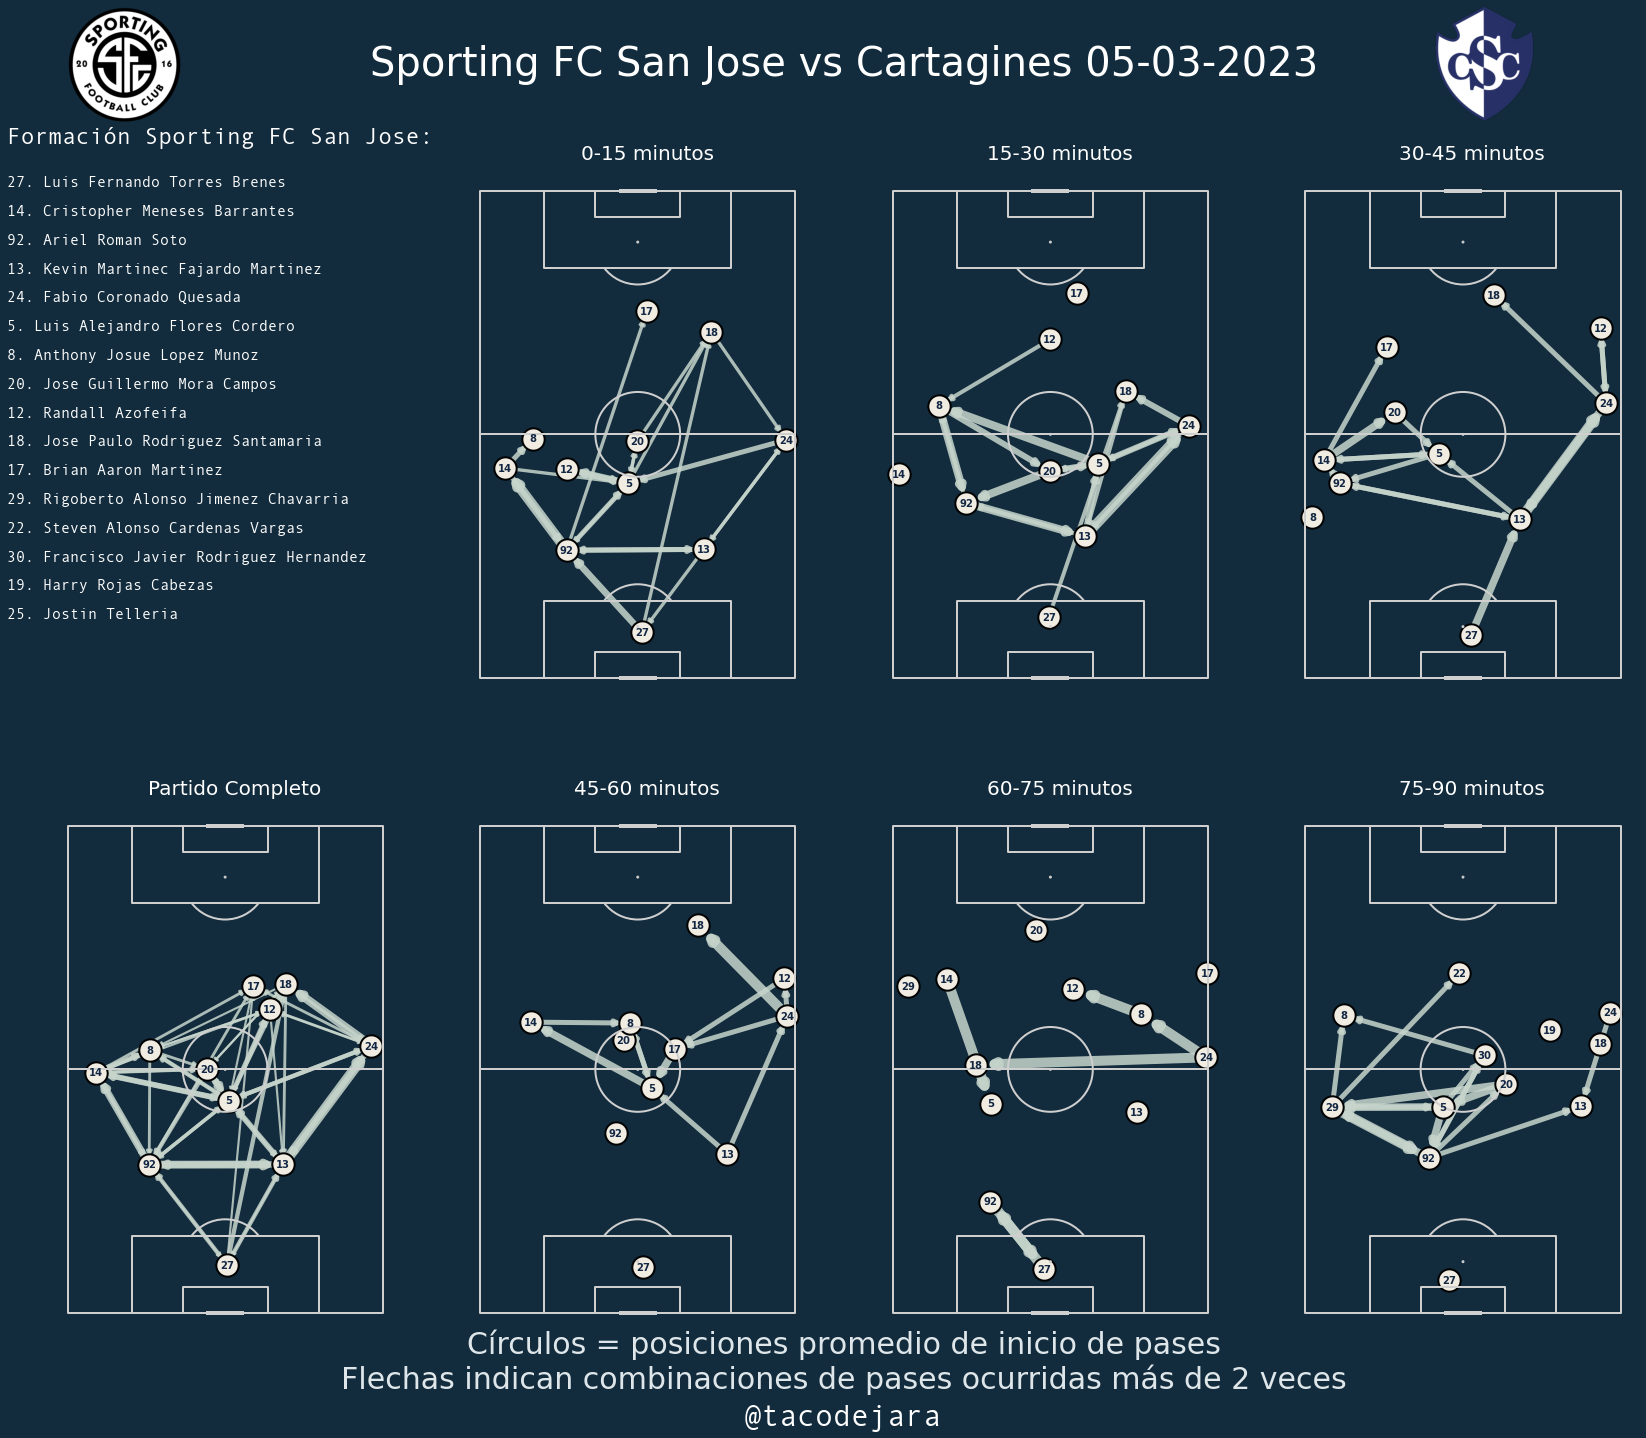

In [20]:
#plot pitch
pitch = VerticalPitch(pitch_type='custom',half=False,pitch_length = 105 , pitch_width = 68, line_color='#cfcfcf', line_zorder=2, pitch_color='#122c3d',pad_top=15)
fig, axs = pitch.grid(nrows=2, ncols=4,
                      figheight=20,
                      endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)

#plot arrows
def pass_line_template(ax, x, y, end_x, end_y, width, line_color):
    ax.annotate('', xy=(end_y, end_x), xytext=(y, x), zorder=1,
    arrowprops=dict(arrowstyle='-|>', linewidth=width, color='#c7d5cc', alpha=.85))
    
def pass_line_template_shrink(ax, x, y, end_x, end_y, width, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y-y, end_x-x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, width, line_color=line_color)
    

for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][1,0],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][1,0], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][1,0])

axs['pitch'][1,0].text(32, 113, 'Partido Completo',
            ha='center', va='center', fontsize=20, color='w')

#save the plot
#plt.savefig(teamA+'_'+datestr+'.png', dpi = 500, bbox_inches='tight',facecolor='#22312b')

#plt.savefig('PPDA del partido '+teamA+' vs '+teamB+'.png',dpi=200) 
#plt.show()

#0-15 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[successful['start_min'] < 15]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][0,1],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][0,1], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][0,1])

axs['pitch'][0,1].text(32, 113, '0-15 minutos',
            ha='center', va='center', fontsize=20, color='w')

#15-30 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 30) & (successful['start_min'] > 15) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][0,2],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][0,2], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][0,2])

axs['pitch'][0,2].text(32, 113, '15-30 minutos',
            ha='center', va='center', fontsize=20, color='w')

#30-45 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 45) & (successful['start_min'] > 30) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][0,3],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][0,3], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][0,3])

axs['pitch'][0,3].text(32, 113, '30-45 minutos',
            ha='center', va='center', fontsize=20, color='w')

#45-60 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 60) & (successful['start_min'] > 45) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][1,1],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][1,1], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][1,1])

axs['pitch'][1,1].text(32, 113, '45-60 minutos',
            ha='center', va='center', fontsize=20, color='w')

#60-75 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 75) & (successful['start_min'] > 60) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][1,2],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][1,2], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][1,2])

axs['pitch'][1,2].text(32, 113, '60-75 minutos',
            ha='center', va='center', fontsize=20, color='w')

#75-90 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 100) & (successful['start_min'] > 75) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][1,3],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][1,3], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][1,3])

axs['pitch'][1,3].text(32, 113, '75-90 minutos',
            ha='center', va='center', fontsize=20, color='w')
#annotatios
#ax.set_title(teamA + " vs "+teamB+" " + datestr + " |Primeros 45 minutos", fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=-8)

#fig.text(.44,-.01,f'@tacodejara / twitter',fontstyle='italic',fontsize=12,fontfamily='Andale Mono',color='w')


# remove unused axes (if any)
#for ax in axs['pitch'].flat[11 + num_sub:-1]:
#    ax.remove()
axs['pitch'][0,0].remove()
#save the plot
#plt.savefig(teamA+'_'+datestr+'_1stHalf.png', dpi = 500, bbox_inches='tight',facecolor='#22312b')

#plt.savefig('PPDA del partido '+teamA+' vs '+teamB+'_vuelta.png',dpi=200) 

# endnote and title
axs['endnote'].text(0.5, 0.3, "Círculos = posiciones promedio de inicio de pases\nFlechas indican combinaciones de pases ocurridas más de 2 veces", va='center', ha='center', fontsize=30,
                    color='#dee6ea')

TITLE = teamA + " vs "+teamB+" " + datestr
title = axs['title'].text(0.5, 0.5, TITLE, ha='center', va='center', fontsize=40, color='w')

#annotatios
#axs['pitch'][0,0].set_title(teamA + " vs "+teamB+" " + datestr + " |Hasta primera sustitución", fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=-8)

fig.text(.44,-.01,f'@tacodejara',fontstyle='italic',fontsize=30,fontfamily='Andale Mono',color='w')

fig.text(0.0,0.88,'Formación ' + teamA + ':',fontsize=23,fontfamily='Andale Mono',color='w', fontweight='bold')

#fig.text(0,0.90,'Formaciones:',fontstyle='italic',fontsize=12,fontfamily='Andale Mono',color='w')
pos_y = 0.85
for index,row in lineups_TeamA.iterrows():
    fig.text(0.0,pos_y,row.code,fontstyle='italic',fontsize=15,fontfamily='Andale Mono',color='w')
    pos_y = pos_y - .02

#Set the background color
#fig.patch.set_facecolor('#22312b')
fig.patch.set_facecolor('#122c3d')




# plot logos (same height as the title_ax)
# set the barca logo to align with the left/bottom of the title axes
ax_barca_logo = add_image(barca_logo, fig,
                          left=axs['title'].get_position().x0,
                          bottom=axs['title'].get_position().y0,
                          height=axs['title'].get_position().height)
# set the deportivo logo to align with the right/bottom of the title axes
# to get the left position to align with the pitches I plotted it once with a random
# left position (e.g. 0.5) and then used the following code
# bbox_logo = ax_deportivo_logo.get_position()
# bbox_title = axs['title'].get_position()
# left = bbox_title.x1 - bbox_logo.width
ax_deportivo_logo = add_image(deportivo_logo, fig, left=0.8521,
                              bottom=axs['title'].get_position().y0,
                              height=axs['title'].get_position().height)


#save the plot
plt.savefig(teamA+'_'+datestr+'.png', dpi = 200, bbox_inches='tight',facecolor='#122c3d')
plt.show()



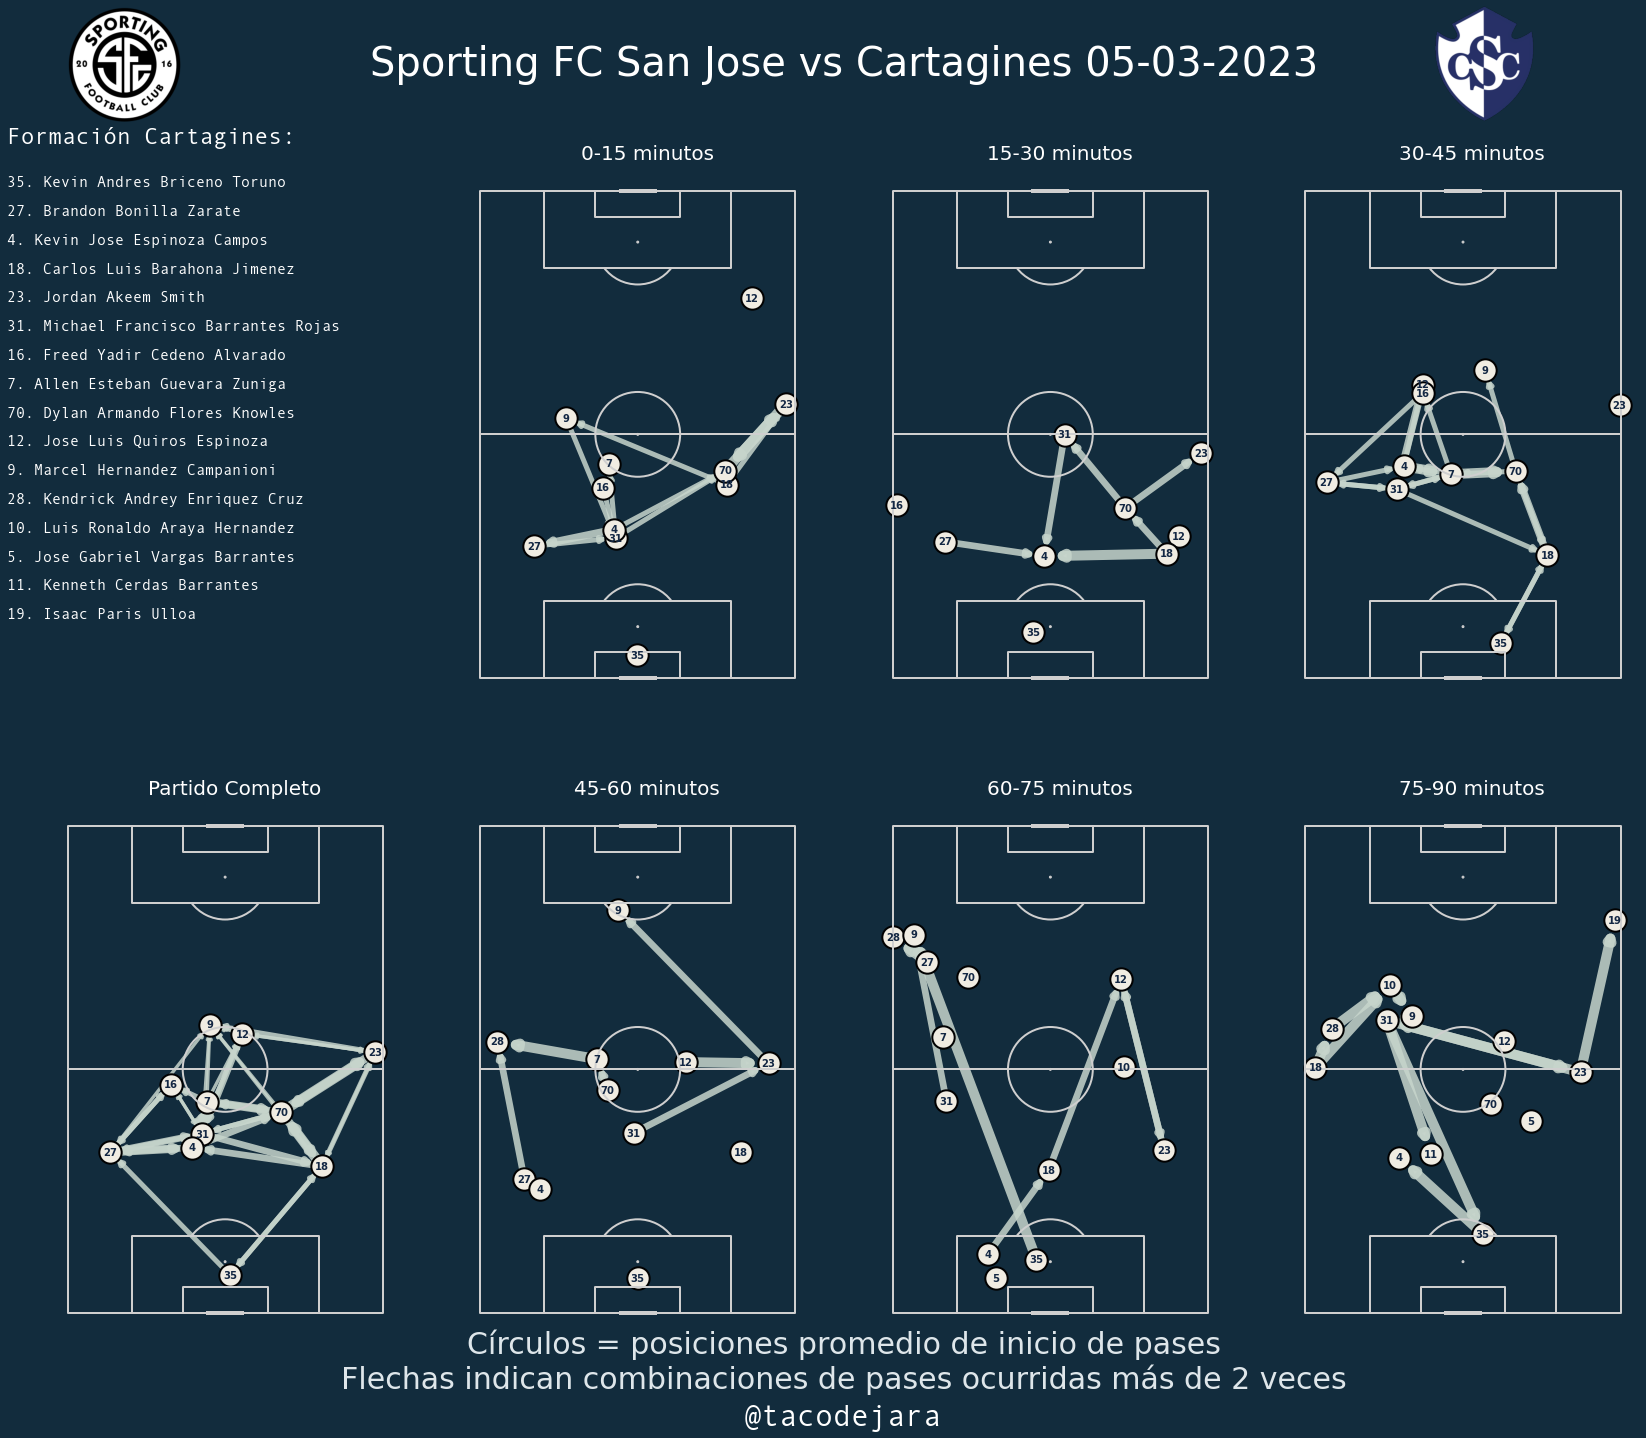

In [21]:
#TEAM B-------------------------------------------------------------------------------

df3 = pd.concat([df2['ID'], df2['start'], df2['end'], df2['code'], df2['pos_x'],df2['pos_y'],df2['match_id'],df2[0].apply(pd.Series),df2[1].apply(pd.Series),df2[2].apply(pd.Series)], axis=1)

list(df3.columns)

df3.columns = ['ID',
 'start',
 'end',
 'code',
 'pos_x',
 'pos_y',
 'match_id',
 0,
 'groupTeam',
 'Team',
 0,
 'groupAction',
 'Action',
 0,
 'groupHalf',
 'Half']


passes_actions = ['Passes accurate', 'Passes (inaccurate)']
defensive_actions = ['Tackles','Interceptions','Fouls','Challenges (won)']


df3['start_min'] = df3['start'].astype(float) / 60
df3['end_min'] =   df3['end'].astype(float) / 60


name_sort_order = dict(zip(lineups_df['code'], lineups_df['sort_order']))
df3['sort_order'] = df3['code'].map(name_sort_order).fillna('')


#filter df to get only the team we want
df3 = df3[df3['Team']==teamB]


df3 = df3[(df3['Action']!="Positional attacks") & (df3['Action']!="Counter-attacks")& (df3['Action']!="Interceptions")
          
          & (df3['Action']!="Picking-ups (in opp. half)") & (df3['Action']!="Picking-ups") & (df3['Action']!="Throw-in attacks")
          
          & (df3['Action']!="Passes into the penalty box") & (df3['Action']!="Free-kick attacks") & (df3['Action']!="Corner attacks")
          
          & (df3['Action']!="Goal-kicks") & (df3['Action']!="Air challenges (won)") & (df3['Action']!="Key passes (accurate)")]



#now we want to find our passes and recipients and then filter for only passes
df3['passer'] = df3['code']

passing_output=[]
from itertools import tee

def next_row(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

for (passer_index, passer_data), (recipient_index, recipient_data) in next_row(df3.iterrows()):
    if passer_data['code'] != recipient_data['code'] and passer_data['Action'] == 'Passes accurate':
        passing_output.append((passer_index, passer_data["ID"], passer_data['code'],\
                             recipient_index, recipient_data["ID"], recipient_data['code']))
            

df5 = pd.DataFrame(passing_output)



name_recipient = dict(zip(df5[1], df5[5]))
df3['recipient'] = df3['ID'].map(name_recipient).fillna('')

#df3['recipient'] = df3['code'].shift(-1)

#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']


sort_order_subsB = lineups_TeamB[lineups_TeamB['sort_order'] > max_sort_order_TeamA + 11]

#find the first subsititution and filter the successful dataframe to be less than that minute
subs = df3[df3['sort_order'].isin(sort_order_subsB['sort_order'])]
subs = subs['start_min']
firstSubB = subs.min()

successful = successful[successful['start_min'] < firstSubB]


successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']


size=1000
radius = math.sqrt(size)/2.


#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])



arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

#plot pitch
pitch = VerticalPitch(pitch_type='custom',half=False,pitch_length = 105 , pitch_width = 68, line_color='#cfcfcf', line_zorder=2, pitch_color='#122c3d',pad_top=15)
fig, axs = pitch.grid(nrows=2, ncols=4,
                      figheight=20,
                      endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)

#plot arrows
def pass_line_template(ax, x, y, end_x, end_y, width, line_color):
    ax.annotate('', xy=(end_y, end_x), xytext=(y, x), zorder=1,
    arrowprops=dict(arrowstyle='-|>', linewidth=width, color='#c7d5cc', alpha=.85))
    
def pass_line_template_shrink(ax, x, y, end_x, end_y, width, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y-y, end_x-x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, width, line_color=line_color)
    

for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][1,0],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][1,0], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][1,0])

axs['pitch'][1,0].text(32, 113, 'Partido Completo',
            ha='center', va='center', fontsize=20, color='w')

#save the plot
#plt.savefig(teamA+'_'+datestr+'.png', dpi = 500, bbox_inches='tight',facecolor='#22312b')

#plt.savefig('PPDA del partido '+teamA+' vs '+teamB+'.png',dpi=200) 
#plt.show()

#0-15 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[successful['start_min'] < 15]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][0,1],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][0,1], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][0,1])

axs['pitch'][0,1].text(32, 113, '0-15 minutos',
            ha='center', va='center', fontsize=20, color='w')

#15-30 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 30) & (successful['start_min'] > 15) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][0,2],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][0,2], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][0,2])

axs['pitch'][0,2].text(32, 113, '15-30 minutos',
            ha='center', va='center', fontsize=20, color='w')

#30-45 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 45) & (successful['start_min'] > 30) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][0,3],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][0,3], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][0,3])

axs['pitch'][0,3].text(32, 113, '30-45 minutos',
            ha='center', va='center', fontsize=20, color='w')

#45-60 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 60) & (successful['start_min'] > 45) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][1,1],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][1,1], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][1,1])

axs['pitch'][1,1].text(32, 113, '45-60 minutos',
            ha='center', va='center', fontsize=20, color='w')

#60-75 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 75) & (successful['start_min'] > 60) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][1,2],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][1,2], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][1,2])

axs['pitch'][1,2].text(32, 113, '60-75 minutos',
            ha='center', va='center', fontsize=20, color='w')

#75-90 minutes....................................................................
#find passes and then only look for the successful passes
passes = df3[df3['Action']=='Passes accurate']
successful = passes[passes['Action']=='Passes accurate']

successful = successful[(successful['start_min'] < 100) & (successful['start_min'] > 75) ]

successful['pos_x'] = successful['pos_x'].astype(float) 
successful['pos_y'] = successful['pos_y'].astype(float) 

df3['pos_x'] = df3['pos_x'].astype(float) 
df3['pos_y'] = df3['pos_y'].astype(float) 

#now we need to find the average locations and counts of the passes
average_locations = successful.groupby('passer').agg({'pos_x':['mean'],'pos_y':['mean','count']})
average_locations.columns = ['pos_x','pos_y','count']

#now we need to find the number of passes between each player
pass_between = successful.groupby(['passer','recipient']).ID.count().reset_index()
pass_between.rename({'ID':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

arrow = mpl.patches.FancyArrowPatch(posA=(1.2*pass_between.pos_x,80-.8*pass_between.pos_y), 
                                    posB=(1.2*pass_between.pos_x_end,80-.8*pass_between.pos_y_end), 
                                    arrowstyle='-|>', mutation_scale=20, shrinkA=radius, shrinkB=radius)

#set minimum threshold of combinations.. I like 5 for high passing teams. 2 or 3 for low passing.
pass_between = pass_between[pass_between['pass_count']>=2]

# Calculate Line Width
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           10)

#Make arrows less transparent if they have a higher count, totally optional of course
min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency


for index, row in pass_between.iterrows():
    pass_line_template_shrink(axs['pitch'][1,3],row['pos_x'],row['pos_y'],row['pos_x_end'],row['pos_y_end'],row['width'],'white')


#plot nodes
pass_nodes = pitch.scatter(average_locations.pos_x, average_locations.pos_y, s=500, #s=500
                           c='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=axs['pitch'][1,3], zorder=2)


#Uncomment these next two lines to get each node labeled with the player id. Check to see if anything looks off, and make note of each player if you're going to add labeles later like their numbers
for index, row in average_locations.iterrows():
     pitch.annotate(row.name[0:2].replace(".",""), xy=(row.pos_x, row.pos_y), c='#132743', va='center', ha='center', size=10, fontweight='bold', fontfamily="Century Gothic",ax=axs['pitch'][1,3])

axs['pitch'][1,3].text(32, 113, '75-90 minutos',
            ha='center', va='center', fontsize=20, color='w')
#annotatios
#ax.set_title(teamA + " vs "+teamB+" " + datestr + " |Primeros 45 minutos", fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=-8)

#fig.text(.44,-.01,f'@tacodejara / twitter',fontstyle='italic',fontsize=12,fontfamily='Andale Mono',color='w')


# remove unused axes (if any)
#for ax in axs['pitch'].flat[11 + num_sub:-1]:
#    ax.remove()
axs['pitch'][0,0].remove()
#save the plot
#plt.savefig(teamA+'_'+datestr+'_1stHalf.png', dpi = 500, bbox_inches='tight',facecolor='#22312b')

#plt.savefig('PPDA del partido '+teamA+' vs '+teamB+'_vuelta.png',dpi=200) 

# endnote and title
axs['endnote'].text(0.5, 0.3, "Círculos = posiciones promedio de inicio de pases\nFlechas indican combinaciones de pases ocurridas más de 2 veces", va='center', ha='center', fontsize=30,
                    color='#dee6ea')

TITLE = teamA + " vs "+teamB+" " + datestr
title = axs['title'].text(0.5, 0.5, TITLE, ha='center', va='center', fontsize=40, color='w')

#annotatios
#axs['pitch'][0,0].set_title(teamA + " vs "+teamB+" " + datestr + " |Hasta primera sustitución", fontsize=18, color="w", fontfamily="Andale Mono", fontweight='bold', pad=-8)

fig.text(.44,-.01,f'@tacodejara',fontstyle='italic',fontsize=30,fontfamily='Andale Mono',color='w')

fig.text(0.0,0.88,'Formación ' + teamB + ':',fontsize=23,fontfamily='Andale Mono',color='w', fontweight='bold')

#fig.text(0,0.90,'Formaciones:',fontstyle='italic',fontsize=12,fontfamily='Andale Mono',color='w')
pos_y = 0.85
for index,row in lineups_TeamB.iterrows():
    fig.text(0.0,pos_y,row.code,fontstyle='italic',fontsize=15,fontfamily='Andale Mono',color='w')
    pos_y = pos_y - .02

#Set the background color
fig.patch.set_facecolor('#122c3d')


# plot logos (same height as the title_ax)
# set the barca logo to align with the left/bottom of the title axes
ax_barca_logo = add_image(barca_logo, fig,
                          left=axs['title'].get_position().x0,
                          bottom=axs['title'].get_position().y0,
                          height=axs['title'].get_position().height)
# set the deportivo logo to align with the right/bottom of the title axes
# to get the left position to align with the pitches I plotted it once with a random
# left position (e.g. 0.5) and then used the following code
# bbox_logo = ax_deportivo_logo.get_position()
# bbox_title = axs['title'].get_position()
# left = bbox_title.x1 - bbox_logo.width
ax_deportivo_logo = add_image(deportivo_logo, fig, left=0.8521,
                              bottom=axs['title'].get_position().y0,
                              height=axs['title'].get_position().height)


#save the plot
plt.savefig(teamB+'_'+datestr+'.png', dpi = 200, bbox_inches='tight',facecolor='#122c3d')

#plt.savefig('PPDA del partido '+teamA+' vs '+teamB+'_vuelta.png',dpi=200) 
plt.show()
